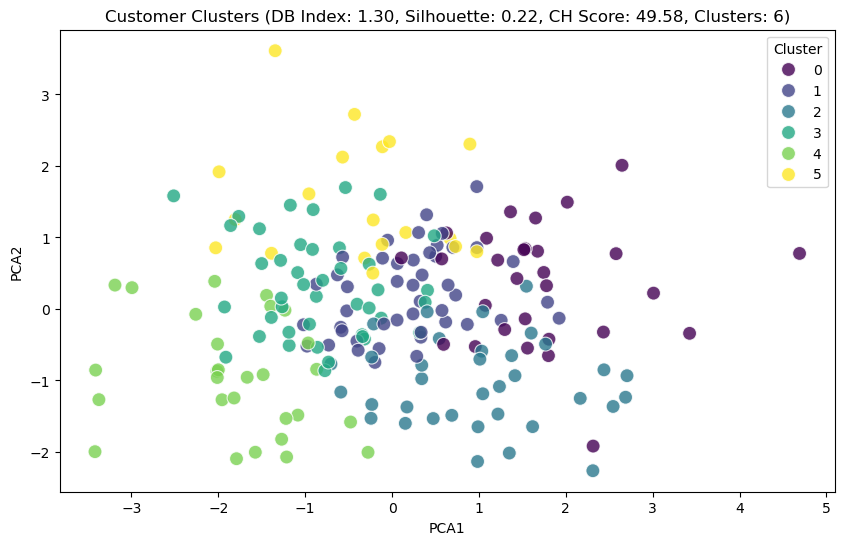

Best Number of Clusters: 6
Best DB Index: 1.30
Best Silhouette Score: 0.22
Best Calinski-Harabasz Score: 49.58


In [17]:
import pandas as pd
import numpy as np
from threadpoolctl import threadpool_limits
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

threadpool_limits(limits=1)


customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')


merged_data = pd.merge(transactions, customers, on='CustomerID', how='inner')


customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count',
    'Price': 'mean',
    'SignupDate': 'first'
}).rename(columns={
    'TotalValue': 'TotalPurchaseValue',
    'TransactionID': 'TransactionCount',
    'Price': 'AvgTransactionValue'
}).reset_index()


customer_features['SignupDate'] = pd.to_datetime(customer_features['SignupDate'])
customer_features['DaysSinceSignup'] = (pd.Timestamp('2025-01-01') - customer_features['SignupDate']).dt.days


region_encoder = LabelEncoder()
customers['RegionEncoded'] = region_encoder.fit_transform(customers['Region'])
customer_features = customer_features.merge(customers[['CustomerID', 'RegionEncoded']], on='CustomerID', how='left')


customer_features = customer_features.drop(columns=['SignupDate'])


scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop(columns=['CustomerID']))


results = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, cluster_labels)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    ch_score = calinski_harabasz_score(scaled_features, cluster_labels)
    results.append((n_clusters, db_index, silhouette_avg, ch_score))


best_n_clusters, best_db_index, best_silhouette, best_ch_score = min(results, key=lambda x: x[1])


kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)


pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
customer_features['PCA1'] = pca_features[:, 0]
customer_features['PCA2'] = pca_features[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=customer_features,
    palette='viridis', s=100, alpha=0.8
)
plt.title(f'Customer Clusters (DB Index: {best_db_index:.2f}, Silhouette: {best_silhouette:.2f}, CH Score: {best_ch_score:.2f}, Clusters: {best_n_clusters})')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()


print(f"Best Number of Clusters: {best_n_clusters}")
print(f"Best DB Index: {best_db_index:.2f}")
print(f"Best Silhouette Score: {best_silhouette:.2f}")
print(f"Best Calinski-Harabasz Score: {best_ch_score:.2f}")


